<a href="https://colab.research.google.com/github/aleks-haksly/KarpovCources_Hard_DA_advanced/blob/main/03%20-%20Advanced%20experiments%20design/12_causal_impact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install clickhouse-driver --q
from clickhouse_driver import Client
from google.colab import userdata
import statsmodels.formula.api as sm
import statsmodels.api as smp
from scipy.stats import ttest_1samp
from itertools import combinations
from tqdm.notebook import tqdm
!pip install pycausalimpact --q
from causalimpact import CausalImpact
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import statsmodels.tsa.stattools as smt

In [ ]:
# Реквизиты для подключения к БД
user = 'hardda_student_alekse-fomin'
password = userdata.get('HA[hardda_student_alekse-fomin]')

host='clickhouse.lab.karpov.courses'
port=9000
database_r='hardda' # БД с правами только на чтение

In [ ]:
# Создаем соединение с БД ClickHouse
client_r = Client(host=host, port=port, user=user,
                password=password, database=database_r)

In [ ]:
#
sql = """
SELECT
  event_date,
  platform,
  SUM(cnt_add_to_favorites) AS cnt_fav,
  SUM(cnt_view_advertisement) AS cnt_view,
  SUM(cnt_display_phone) AS cnt_display_phone,
  cnt_fav / cnt_view AS cr
FROM
  user_dm_events
WHERE
  event_date BETWEEN '2022-02-01' AND '2022-07-15'
GROUP BY
  event_date,
  platform
"""
result, columns = client_r.execute(sql, with_column_types=True)
data = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

In [ ]:
data['event_date'] = pd.to_datetime(data['event_date'])

## Задание 1 (1/2) ##


Агрегируйте датасет по дням, где одна строка датасета - один день, а по столбцам - метрики. На каждую комбинацию (платформа-метрика) отдельный столбец. Постройте график динамики метрики cr в разрезе платформ.

Укажите среднюю по целевой метрике отношения в платформе IOS ('cr_ios') по дням до нововведения (меньше '2022-07-01')

In [ ]:
df = data.pivot_table(index='event_date', columns='platform', values=['cnt_fav', 'cnt_view', 'cnt_display_phone',
       'cr'], aggfunc='sum')

In [ ]:
df.columns = ['_'.join(col).strip() for col in df.columns.values]

In [ ]:
df["intervention"] = np.where(df.index < '2022-07-01', 0, 1)

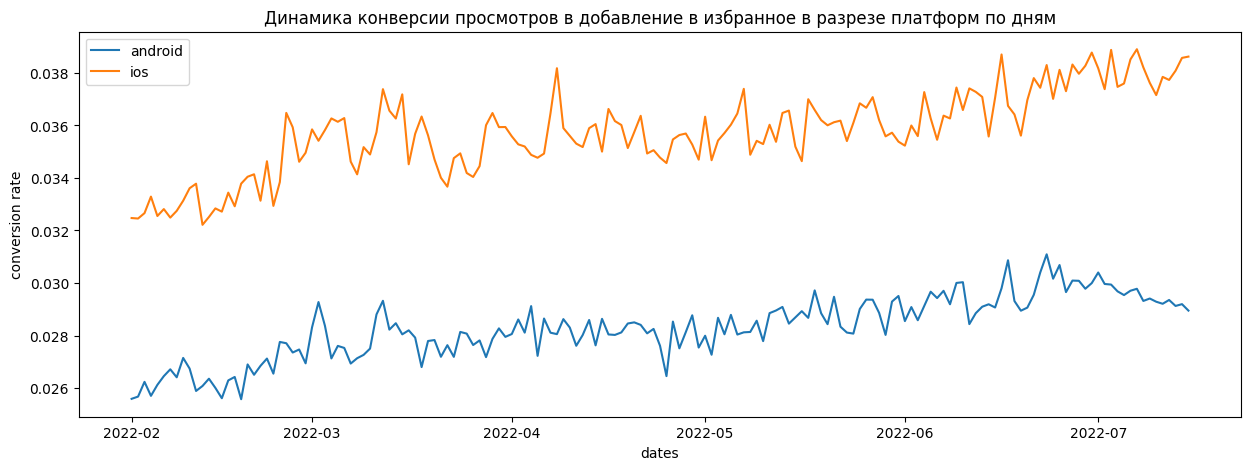

In [ ]:
fig, axes = plt.subplots(figsize=(15, 5))
sns.lineplot(data=df, x=df.index, y='cr_android', label='android')
sns.lineplot(data=df, x=df.index, y='cr_ios', label='ios')
plt.xlabel('dates')
plt.ylabel('conversion rate')
plt.title('Динамика конверсии просмотров в добавление в избранное в разрезе платформ по дням')
plt.legend(loc="upper left");

In [ ]:
cr_ios_mean_0 = df[df['intervention'] == 0]['cr_ios'].mean()
print(f"Cреднюяя по целевой метрике отношения в платформе IOS по дням до нововведения {cr_ios_mean_0:.3f}")

Cреднюяя по целевой метрике отношения в платформе IOS по дням до нововведения 0.036


## Задание 1 (2/2) ##


Укажите среднюю по целевой метрике отношения в платформе IOS ('cr_ios') по дням после нововведения (>= '2022-07-01')

Введите значение в поле ниже с точностью до трех знаков в десятичной части.

In [ ]:
cr_ios_mean_1 = df[df['intervention'] == 1]['cr_ios'].mean()
print(f"Cреднюяя по целевой метрике отношения в платформе IOS по дням после нововведения {cr_ios_mean_1:.3f}")

Cреднюяя по целевой метрике отношения в платформе IOS по дням после нововведения 0.038


## Задание 2 ##


Постройте корреляционную матрицу. Её нужно строить по pre данным.

Найдите три наиболее скоррелированные с целевой метрикой сr_ios (именно в IOS у нас было воздействие) ковариаты.

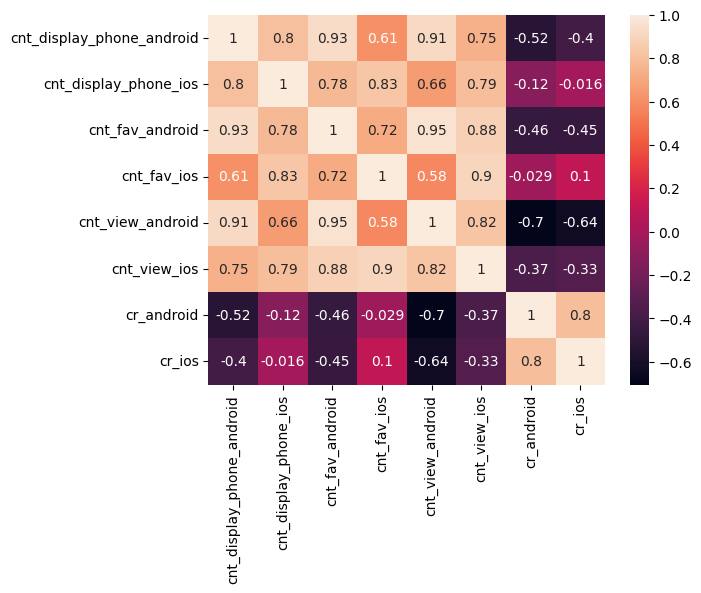

In [ ]:
sns.heatmap(df.query('intervention == 0').iloc[:,:-1].corr(), annot=True);

In [ ]:
df.query('intervention == 0').iloc[:,:-1].corr()['cr_ios'].sort_values(ascending=False, key=lambda x: abs(x))[1:4].to_frame()

,cr_ios
cr_android,0.800127
cnt_view_android,-0.635744
cnt_fav_android,-0.454857


## Задание 3 (1/2) ##
   

Проведите разовый Causal Impact анализ на метрику cr_ios и тремя лучшими метриками ковариатами, где днем intervention является 2022-07-01. Отвергается ли нулевая гипотеза?

In [ ]:
intervention_start_date = pd.to_datetime('2022-07-01')

In [ ]:
# Первой должна идти целевая переменная y, далее ковариаты X
ci_df = df[['cr_ios', 'cr_android', 'cnt_view_android', 'cnt_fav_android']].copy()

In [ ]:
pre_period = [ci_df.index.min(), intervention_start_date - pd.DateOffset(1)]
post_period = [intervention_start_date, ci_df.index.max()]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

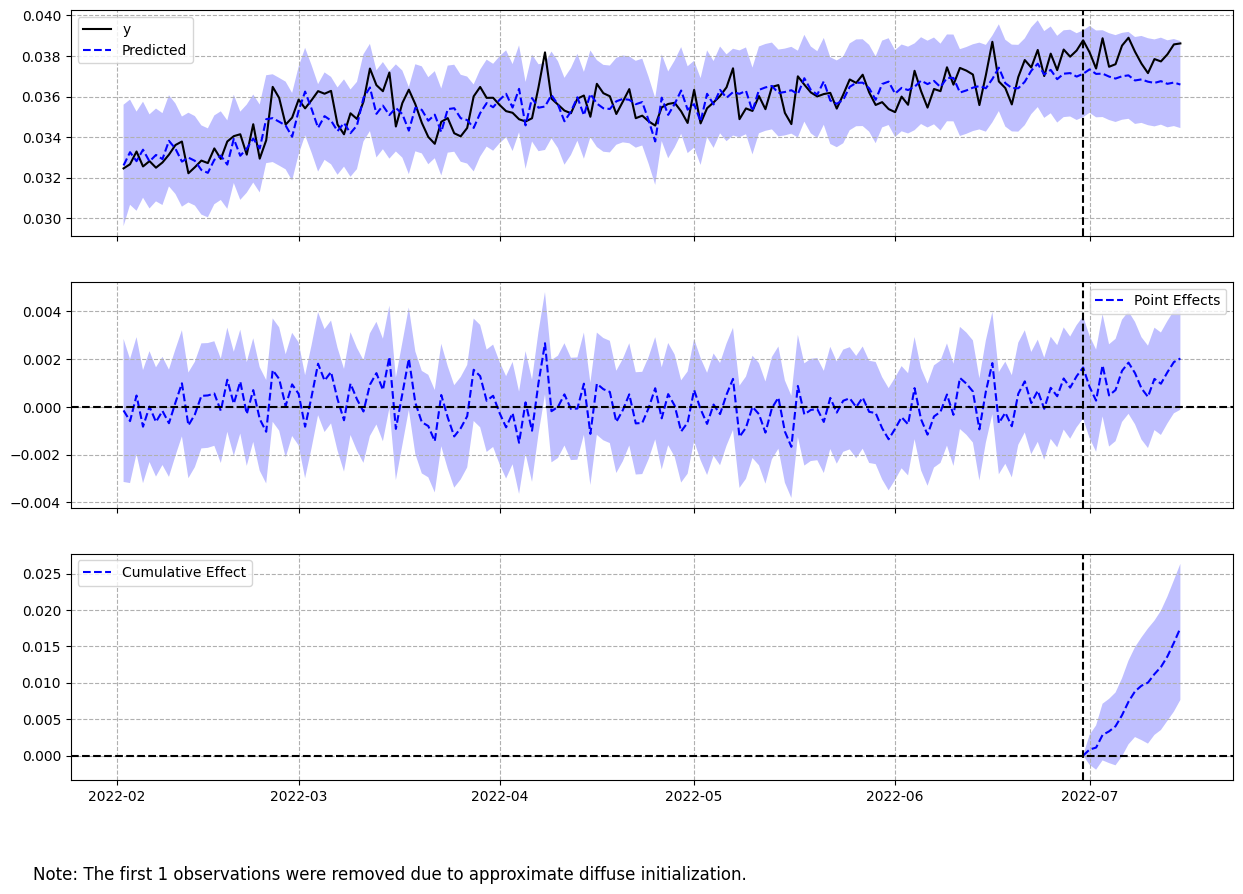

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.04               0.57
Prediction (s.d.)         0.04 (0.0)         0.55 (0.0)
99% CI                    [0.04, 0.04]       [0.54, 0.56]

Absolute effect (s.d.)    0.0 (0.0)          0.02 (0.0)
99% CI                    [0.0, 0.0]         [0.01, 0.03]

Relative effect (s.d.)    3.17% (0.66%)      3.17% (0.66%)
99% CI                    [1.38%, 4.76%]     [1.38%, 4.76%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [ ]:
ci = CausalImpact(ci_df, pre_period, post_period, alpha = 0.01)
ci.plot(figsize = (15, 10))
print(ci.summary());

## Задание 3 (2/2) ##


Какой относительный размер эффекта находит модель?

Введите значение в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [ ]:
ci.summary_data

,average,cumulative
actual,0.038048,0.570724
predicted,0.036879,0.553190
predicted_lower,0.036292,0.544377
predicted_upper,0.037538,0.563077
abs_effect,0.001169,0.017533
abs_effect_lower,0.000510,0.007647
abs_effect_upper,0.001756,0.026346
rel_effect,0.031694,0.031694
rel_effect_lower,0.013823,0.013823
rel_effect_upper,0.047626,0.047626


In [ ]:
rel_effect = ci.summary_data['average'].loc['rel_effect']

In [ ]:
print(f'модель находит относительный размер эффекта = {rel_effect:.3f}' )

модель находит относительный размер эффекта = 0.032


## Задание 4 ##


Какие элементы регрессионного уравнения имеют p-value < 0.05?

Проведите анализ коэффициентов модели.

In [ ]:
ci.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                 cr_ios   No. Observations:                  150
Model:                    local level   Log Likelihood                -131.619
Date:                Tue, 23 Jul 2024   AIC                            273.239
Time:                        08:02:11   BIC                            288.258
Sample:                    02-01-2022   HQIC                           279.341
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
sigma2.irregular          0.3265      0.043      7.519      0.000       0.241       0.412
sigma2.level              0.0001      0.000      0.376      0.707      -0.001       0.001
beta.cr_android          -0.5684      0.484     -1.173      0.241      -1.518       0.381
beta.cnt_view_android    -3.9016      1.441     -2.707      0.007      -6.726      -1.077
beta.cnt_fav_android      3.0116      1.168      2.579      0.010       0.723       5.300
===================================================================================
Ljung-Box (L1) (Q):                   4.51   Jarque-Bera (JB):                 2.78
Prob(Q):                              0.03   Prob(JB):                         0.25
Heteroskedasticity (H):               0.84   Skew:                             0.31
Prob(H) (two-sided):                  0.53   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
significat_elements = ci.trained_model.pvalues.index[ci.trained_model.pvalues < 0.05].to_list()

In [ ]:
print(f"Элементы {', '.join(significat_elements)} регрессионного уравнения имеют p-value < 0.05")

Элементы sigma2.irregular, beta.cnt_view_android, beta.cnt_fav_android регрессионного уравнения имеют p-value < 0.05


## Задание 5 (1/3) ##


Проведите анализ остатков модели. Укажите верные утверждения по трем гипотезам относительно остатков.

1. Остатки стационарны?

$H_0:$ ряд не стационарен

$H_1:$ ряд стационарен

In [ ]:
pval = smt.adfuller(ci.trained_model.resid)[1]
print("p-value тест Дики-Фуллера = %f" % pval)
print("ряд не стационарен" if pval > 0.05 else "ряд стационарен")

p-value тест Дики-Фуллера = 0.000000
ряд стационарен


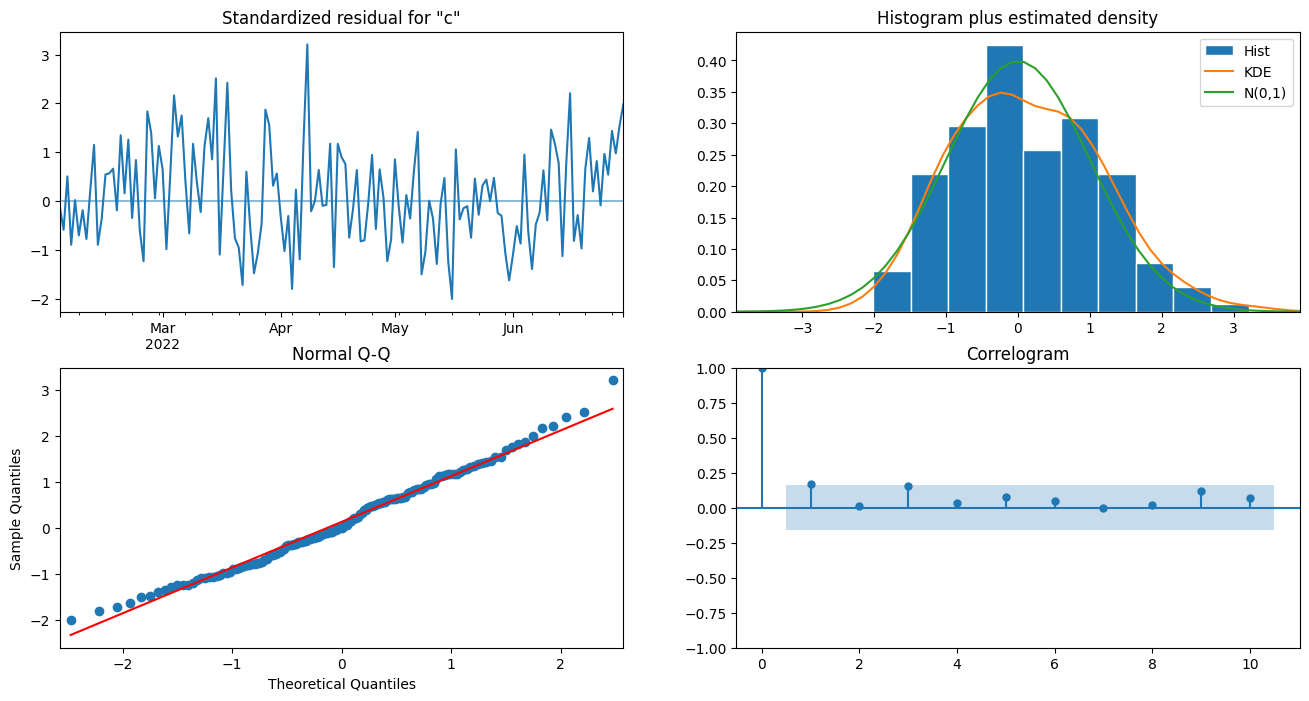

In [ ]:
ci.trained_model.plot_diagnostics(figsize = (16, 8));

## Оценка качества модели:

## Задание 5 (2/3) ##


2. Остатки смещены?

$H_0:$ остатки не смещены относительно 0

$H_1:$ остатки смещены относительно 0

In [ ]:
pval = ttest_1samp(ci.trained_model.resid, 0)[1]
print("p-value тест Стьюдента = %f" % pval)
print("остатки не смещены относительно 0" if pval > 0.05 else "остатки смещены относительно 0")

p-value тест Стьюдента = 0.121894
остатки не смещены относительно 0


## Задание 5 (3/3) ##


3. Остатки автокоррелированы?

$H_0:$ остатки не автокоррелированы (в них нет периодичности)

$H_1:$ остатки автокоррелированы

In [ ]:
pval = ci.trained_model.test_serial_correlation('ljungbox')[0, :, 0][1]
print("p-value тест Льюнга-Бокса = %f" % pval)
print("остатки автокоррелированы" if pval < 0.05 else "остатки не автокоррелированы")

p-value тест Льюнга-Бокса = 0.033779
остатки автокоррелированы


## Задание 6 (1/3) ##


Оцените точность прогноза модели по историческим данным.

Введите значение MAE в поле ниже с точностью до трех знаков в десятичной части.

In [ ]:
y_pred = ci.inferences.loc[:pre_period[1]]['preds']

In [ ]:
y = df.loc[:pre_period[1]]['cr_ios']

In [ ]:
MAE = mean_absolute_error(y_pred, y)
print(f"MAE = {MAE:.3f}")

MAE = 0.001


## Задание 6 (2/3) ##


Оцените точность прогноза модели по историческим данным.

Введите значение MAPE в поле ниже с точностью до трех знаков в десятичной части.

In [ ]:
MAPE = mean_absolute_percentage_error(y_pred, y)
print(f"MAPE = {MAPE:.3f}")

MAPE = 0.019


## Задание 6 (3/3) ##


Оцените точность прогноза модели по историческим данным.

Введите значение R2_score в поле ниже с точностью до трех знаков в десятичной части.

In [ ]:
R2 = r2_score(y, y_pred)
print(f"R2_score = {R2:.3f}")

R2_score = 0.663


## Задание 7 (1/2) ##


Оцените мощность и статистическую значимость методики causal impact в нашем кейсе.

Для симуляции будем использовать следующие вводные:

* три ковариаты с предыдущего анализа (имеющие наилучшую корреляцию с целевой метрикой)
* кол-во дней в условном эксперименте = 14 (n_days = 14 в функции из урока)
* доля зарезервированных под контроль дат = 0.6
* кол-во симуляций для одной комбинации = 30 (sample_n = 30 в функции из урока)

Перед стартом функции обозначьте np.random.seed(1).

Какая комбинация ковариат дает лучшие уровни ошибок первого и второго рода?

In [ ]:
import joblib

def causal_analysis(data, target_value, covariate, n_days = 14, control_percent = 0.6, sample_n = 30):
    '''
    data - исторические данные на которых мы оцениваем ковариату
    covariate - назвние столбца ковариат
    n_days - период в днях на post период
    control_percent - доля датасета зарезервированного под pre период (0.1)
    sample_n - кол-во симуляций

    '''
    n_days -= 1

    data = pd.concat([data.loc[:, [target_value]], data.loc[:, covariate]], axis = 1)

    df_copy = data.copy()
    effects = [0.9, 0.95, 0.975, 1., 1.025, 1.05, 1.1] # Эффекты
    rel_effects = []

    #dates = pd.DataFrame(data.index, columns = ['post_period_0']) # Даты
    dates = pd.DataFrame({'post_period_0': data.index}) # Даты

    # Самая первая дата контрольной группы
    initial = dates.values[0][0]
    # Тестовая группа, подбираем из неё 10 рандомных дат
    test = dates.iloc[int(len(dates)*(control_percent)):-n_days]\
                .sample(sample_n, random_state = 123, replace = True)\
    # Определяем пост и пре период
    test['post_period_1'] = test.post_period_0 + pd.DateOffset(days = n_days)
    test['pre_period_0'] = initial
    test['pre_period_1'] = test.post_period_0 - pd.DateOffset(days = 1)

    test = test.astype(str)
    a = np.empty((sample_n, len(effects) + 2))

    def calculate_sse_mape_pval(d):
        sse = []
        mape = []
        p_vals = []
        for i in range(len(effects)):
            pre_period = [test.pre_period_0.values[d], test.pre_period_1.values[d]]
            post_period = [test.post_period_0.values[d], test.post_period_1.values[d]]

            df_copy = data.copy() # создаём другую переменную дубликата датафрейма чтобы каждый раз задавать новый эффект

            df_copy.loc[np.logical_and(
                        df_copy.index >= post_period[0], df_copy.index <= post_period[1]), target_value] *= effects[i] # задаём эффект
            ci = CausalImpact(df_copy, pre_period, post_period)

            relative_eff = ci.summary_data.loc['rel_effect', :][0].round(3)
            real_eff = effects[i] - 1
            to_sse = pow(relative_eff - real_eff, 2)
            to_mape = abs(relative_eff - real_eff) * 100

            sse.append(to_sse)
            mape.append(to_mape)
            rel_effects.append(relative_eff)
            p_vals.append(ci.p_value)
        return (d, sum(sse), np.mean(mape), p_vals[effects.index(1)], p_vals[effects.index(1.025)],
               p_vals[effects.index(0.975)], p_vals[effects.index(1.05)], p_vals[effects.index(0.95)],
               p_vals[effects.index(1.1)], p_vals[effects.index(0.9)])

    results = joblib.Parallel(n_jobs=-1, verbose = len(test))(joblib.delayed(calculate_sse_mape_pval)(d) for d in range(len(test)))

    for result in results:
        d = result[0]
        a[d][0] = result[1]
        a[d][1] = result[2]
        a[d][2] = result[3]
        a[d][3] = result[4]
        a[d][4] = result[5]
        a[d][5] = result[6]
        a[d][6] = result[7]
        a[d][7] = result[8]
        a[d][8] = result[9]

    aa = pd.DataFrame(a, columns = ['sse', 'mape', 'p_val_1', 'p_val_1_025', 'p_val_0_975',
                                    'p_val_1_05', 'p_val_0_95', 'p_val_1_1', 'p_val_0_9'])
    final = test.reset_index().merge(aa.reset_index(), left_index = True, right_index = True)
    final.drop(columns = ['index_x', 'index_y'], inplace = True)
    final['covariate'] = ', '.join(covariate)
    return final

In [ ]:
best_covariates = ['cr_android', 'cnt_view_android', 'cnt_fav_android']

In [ ]:
def make_combs(covariates:list) -> list:
  '''
  covariates - список названий столбцов датафрейма, которые будем использовать как ковариаты для casual impact анализа
  '''
  combs = list(combinations(covariates, 1))
  for i in range(2, len(covariates) + 1):
      combs.extend(list(combinations(covariates, i)))
  return combs

In [ ]:
%%time
np.random.seed(1)
res = pd.DataFrame()
for comb in make_combs(best_covariates):
    caus = causal_analysis(ci_df.loc[ci_df.index < '2022-07-01'], 'cr_ios', comb)
    res = pd.concat([res, caus], axis = 0)
res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  3

CPU times: user 24.9 s, sys: 5.64 s, total: 30.5 s
Wall time: 43min 49s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.3min finished


,post_period_0,post_period_1,pre_period_0,pre_period_1,sse,mape,p_val_1,p_val_1_025,p_val_0_975,p_val_1_05,p_val_0_95,p_val_1_1,p_val_0_9,covariate
0,2022-06-16,2022-06-29,2022-02-01,2022-06-15,5.880000e-04,9.142857e-01,0.106893,0.000000,0.006993,0.0,0.0,0.0,0.0,cr_android
1,2022-05-04,2022-05-17,2022-02-01,2022-05-03,1.974078e-32,4.361590e-15,0.481518,0.000000,0.000000,0.0,0.0,0.0,0.0,cr_android
2,2022-05-30,2022-06-12,2022-02-01,2022-05-29,4.670000e-04,8.142857e-01,0.114885,0.012987,0.000000,0.0,0.0,0.0,0.0,cr_android
3,2022-06-05,2022-06-18,2022-02-01,2022-06-04,7.000000e-06,1.000000e-01,0.447552,0.000000,0.000000,0.0,0.0,0.0,0.0,cr_android
4,2022-06-09,2022-06-22,2022-02-01,2022-06-08,6.830000e-04,9.857143e-01,0.082917,0.000000,0.009990,0.0,0.0,0.0,0.0,cr_android
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,2022-06-10,2022-06-23,2022-02-01,2022-06-09,4.291000e-03,2.471429e+00,0.000000,0.000000,0.460539,0.0,0.0,0.0,0.0,"cr_android, cnt_view_android, cnt_fav_android"
26,2022-05-04,2022-05-17,2022-02-01,2022-05-03,1.012000e-03,1.200000e+00,0.042957,0.000000,0.028971,0.0,0.0,0.0,0.0,"cr_android, cnt_view_android, cnt_fav_android"
27,2022-05-22,2022-06-04,2022-02-01,2022-05-21,2.650000e-04,6.142857e-01,0.174825,0.000000,0.001998,0.0,0.0,0.0,0.0,"cr_android, cnt_view_android, cnt_fav_android"
28,2022-05-09,2022-05-22,2022-02-01,2022-05-08,4.500000e-04,8.000000e-01,0.128871,0.000000,0.005994,0.0,0.0,0.0,0.0,"cr_android, cnt_view_android, cnt_fav_android"


In [ ]:
# function to aggregate results
def to_res(data, to_group, n, alpha = 0.05):
    def p_val_count_alpha(p_val):
        return np.count_nonzero(p_val < alpha)

    def p_val_count_beta(p_val):
        return np.count_nonzero(p_val >= alpha)

    p_val_cols = data.filter(like = 'p_val').columns

    data['pre_period_diff'] = (pd.to_datetime(data.pre_period_1) - pd.to_datetime(data.pre_period_0))
    res = data.groupby([to_group]).agg({'sse': 'sum',
                                     'mape': 'mean',
                                     p_val_cols[0]: p_val_count_alpha,
                                     p_val_cols[1]: p_val_count_beta,
                                     p_val_cols[2]: p_val_count_beta,
                                     p_val_cols[3]: p_val_count_beta,
                                     p_val_cols[4]: p_val_count_beta,
                                     p_val_cols[5]: p_val_count_beta,
                                     p_val_cols[6]: p_val_count_beta,
                                     'pre_period_diff': 'mean'})

    res[p_val_cols[0]] = res[p_val_cols[0]] / n
    res[p_val_cols[1]] = res[p_val_cols[1]] / n
    res[p_val_cols[2]] = res[p_val_cols[2]] / n
    res[p_val_cols[3]] = res[p_val_cols[3]] / n
    res[p_val_cols[4]] = res[p_val_cols[4]] / n
    res[p_val_cols[5]] = res[p_val_cols[5]] / n
    res[p_val_cols[6]] = res[p_val_cols[6]] / n

    return res

In [ ]:
n_sim = 30
res_conc = to_res(res, 'covariate', n_sim)
res_conc

,sse,mape,p_val_1,p_val_1_025,p_val_0_975,p_val_1_05,p_val_0_95,p_val_1_1,p_val_0_9,pre_period_diff
covariate,,,,,,,,,,
cnt_fav_android,0.152220,2.562857,0.766667,0.000000,0.966667,0.0,0.066667,0.0,0.0,112 days 16:48:00
cnt_view_android,0.030121,0.946190,0.200000,0.000000,0.266667,0.0,0.000000,0.0,0.0,112 days 16:48:00
"cnt_view_android, cnt_fav_android",0.016726,0.830476,0.133333,0.033333,0.000000,0.0,0.000000,0.0,0.0,112 days 16:48:00
cr_android,0.006575,0.461429,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,112 days 16:48:00
"cr_android, cnt_fav_android",0.021343,0.831905,0.400000,0.300000,0.000000,0.0,0.000000,0.0,0.0,112 days 16:48:00
"cr_android, cnt_view_android",0.021581,0.838571,0.400000,0.333333,0.000000,0.0,0.000000,0.0,0.0,112 days 16:48:00
"cr_android, cnt_view_android, cnt_fav_android",0.063858,1.538095,0.600000,0.000000,0.466667,0.0,0.000000,0.0,0.0,112 days 16:48:00


In [ ]:
# Ответ: аналогичная целевая метрика в android
res_conc[['p_val_1', 'p_val_1_025', 'p_val_0_975', 'p_val_1_05',
       'p_val_0_95', 'p_val_1_1', 'p_val_0_9']].mean(axis=1)

covariate
cnt_fav_android                                  0.257143
cnt_view_android                                 0.066667
cnt_view_android, cnt_fav_android                0.023810
cr_android                                       0.000000
cr_android, cnt_fav_android                      0.100000
cr_android, cnt_view_android                     0.104762
cr_android, cnt_view_android, cnt_fav_android    0.152381
dtype: float64